# TP1 Gabriel García

Una plataforma de ventas online nos contrata para que realicemos un modelo que nos permita detectar un posible fraude dada cierta operación para ello contamos con un dataset que contiene las siguientes columnas: 

- Step: representa una unidad de tiempo donde 1 step equivale a 1 hora 
- type: tipo de transacción en línea 
- amount: el importe de la transacción 
- nameOrig: cliente que inicia la transacción 
- oldbalanceOrg: saldo antes de la transacción 
- newbalanceOrig: saldo después de la transacción 
- nameDest: destinatario de la transacción 
- oldbalanceDest: saldo inicial del destinatario antes de la transacción 
- newbalanceDest: el nuevo saldo del destinatario después de la transacción 
- isFraud: transacción fraudulenta

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix

from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve


In [49]:
def plot_roc(fpr, tpr, roc, pr_rec, pr_pre, pr_cur): 

    fig, axes = plt.subplots(1,2,figsize=(18,4))

    axes[0].grid()
    axes[0].set_title('ROC')
    axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc)
    axes[0].legend(loc = 'lower right')
    axes[0].plot([0, 1], [0, 1],'r--')
    axes[0].set_xlim([-0.01, 1])
    axes[0].set_ylim([0, 1])
    axes[0].set_ylabel('Verdaderos Positivos')
    axes[0].set_xlabel('Falsos Positivos')

    axes[1].grid()
    axes[1].set_title('PR ROC')
    axes[1].plot(pr_rec, pr_pre, 'b', label = 'PR_AUC = %0.2f' % pr_cur)
    axes[1].legend(loc = 'lower right')
    axes[1].plot([0, 1], [1, 0],'r--')
    axes[1].set_xlim([-0.01, 1])
    axes[1].set_ylim([0, 1])
    axes[1].set_ylabel('Precision')
    axes[1].set_xlabel('Recall')

In [2]:
# Cargamos dataset
df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

In [5]:
# Miramos 5 primeros registros
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Vemos info correspondiente al dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

El dataset contiene 6362620 registros y no contiene valores nulos en ninguna de las columnas. Además, hay una columna adicional llamada isFlaggedFraud que no está considerada en el análisis inicial, por lo que se procederá a eliminar. Dentro de las 9 variables explicativas, 3 son de tipo category y las otras 6 son numéricas. La variable objetivo es booleana, con 0 cuando no hay fraude y 1 cuando sí lo hay. 

In [8]:
df.drop(columns = ['isFlaggedFraud'], inplace = True)

In [9]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

In [10]:
# Ver información adicional de datos
df.describe(include = 'all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C545315117,NaN,NaN,C1286084959,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00


## EDA

### Variables numéricas

In [11]:
# Filtramos solo variables numéricas
df_num = df.select_dtypes(include='number')

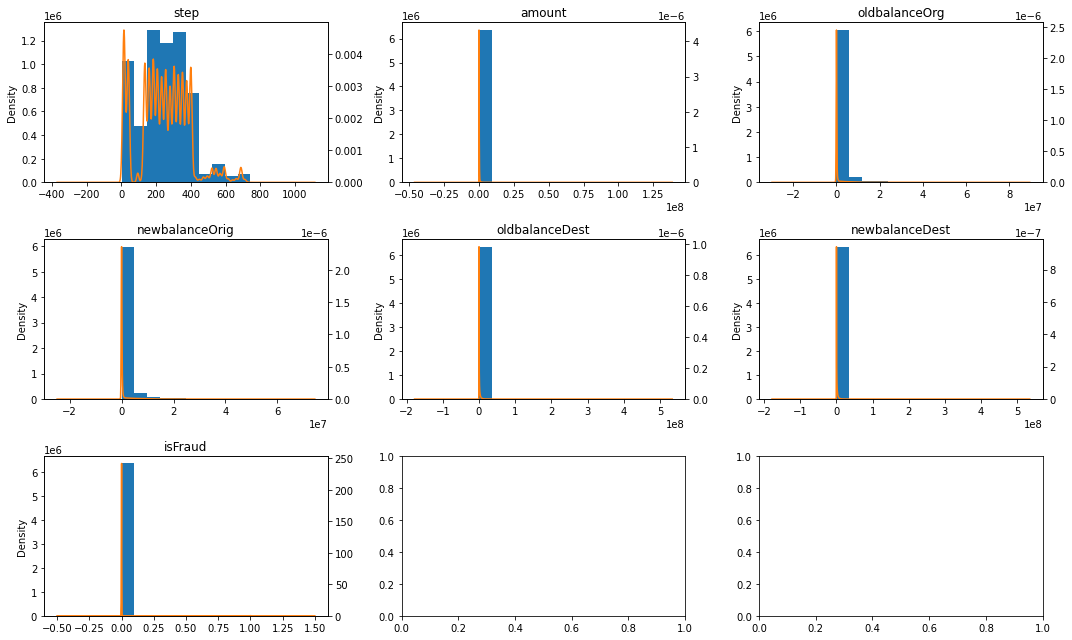

In [22]:
# Grafica de la distribución de cada variable numérica junto con su PDF aproximada
k = len(df_num.columns)
n = 3
m = (k - 1) // n + 1
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(df_num.iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
    ax2.set_ylim(0)

fig.tight_layout()

La mayoría de variables numéricas parece tener un claro sesgo positivo. 

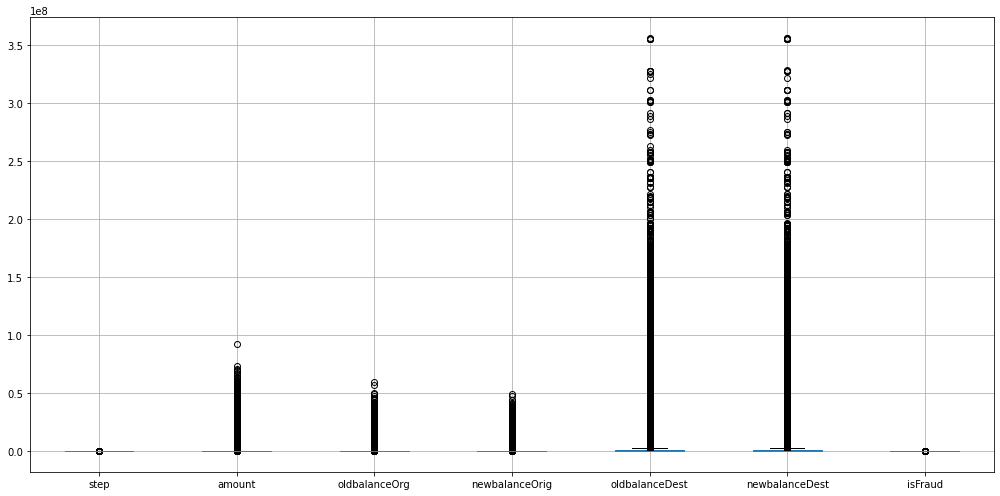

In [12]:
fig = df_num.boxplot(figsize=(14,7))
plt.tight_layout()
plt.show()

Además, parece haber gran cantidad de outliers sobretodo en las variables de balance del destinatario

#### Análisis bivariado con variable de salida

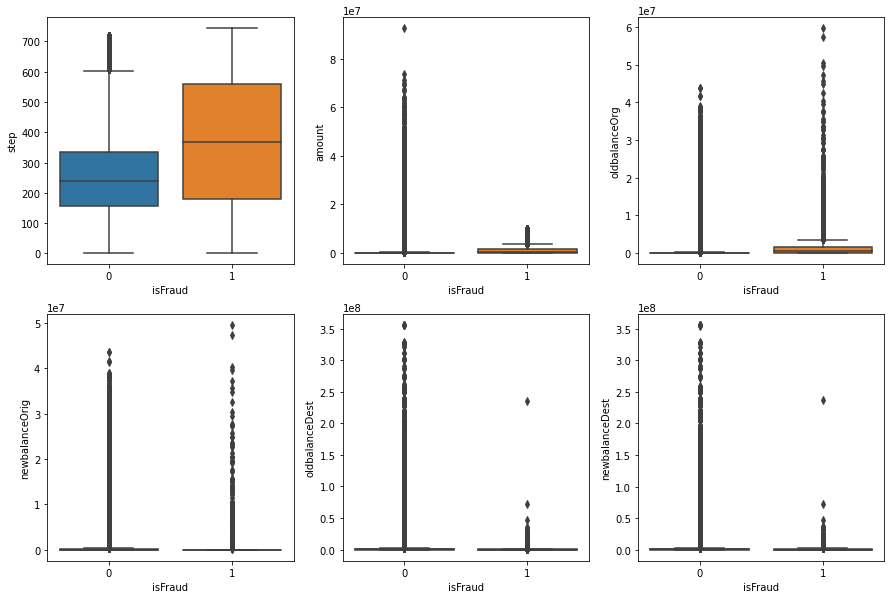

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.boxplot(x="isFraud", y='step', data=df, ax=axes[0][0])
sns.boxplot(x="isFraud", y='amount', data=df, ax=axes[0][1])
sns.boxplot(x="isFraud", y='oldbalanceOrg', data=df, ax=axes[0][2])
sns.boxplot(x="isFraud", y='newbalanceOrig', data=df, ax=axes[1][0])
sns.boxplot(x="isFraud", y='oldbalanceDest', data=df, ax=axes[1][1])
sns.boxplot(x="isFraud", y='newbalanceDest', data=df, ax=axes[1][2])
plt.show()


Vemos que variables como step, amount  y oldbalanceOrg parecen comportarse de forma distinta cuando hay o no hay fraude. 

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


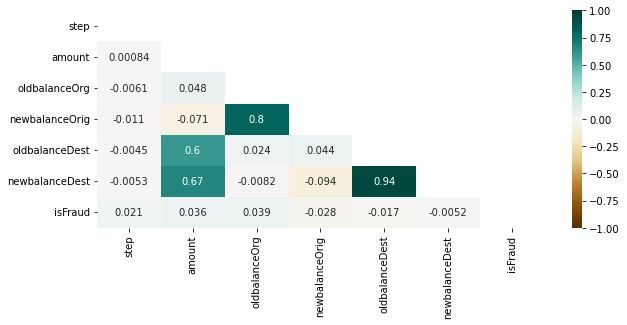

In [14]:
# Compute the correlation matrix
plt.figure(figsize=(10, 4))
mask = np.triu(np.ones_like(df_num.corr(method = 'spearman'), dtype=np.bool))
heatmap = sns.heatmap(df_num.corr(method = 'spearman'), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
#heatmap.set_title(f'{df_num} correlation heatmap', fontdict={'fontsize':18}, pad=16)

De la gráfica anterior vemos que las variables con nuevo y viejo balance tanto en origen como en destino tienen muy alta correlación, y que amount está relacionado monolíticamente con el balance destino.

### Variables categóricas

In [15]:
# Filtramos solo variables numéricas
df_cat = df.select_dtypes(include='O')

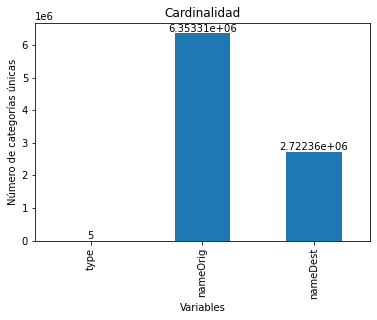

In [16]:
# Cardinalidad

ax = df_cat.nunique().plot.bar()
plt.ylabel('Número de categorías únicas')
plt.xlabel('Variables')
plt.title('Cardinalidad')
ax.bar_label(ax.containers[0])
plt.show()

Según la gráfica, podemos pensar en no trabajar con los nombres de origen y de destino ya que tienen una altísima cardinalidad. Mientras que la variable "type" como solo tiene 5 categorías, podría ser tratada usando OHE. 

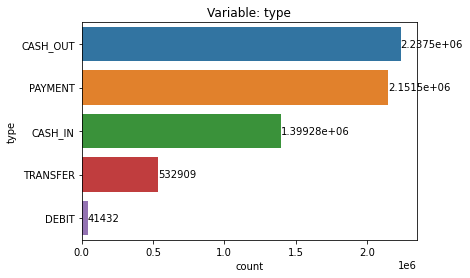

In [17]:
plt.title(f'Variable: type')
ax = sns.countplot(data = df_cat, y = 'type', order=df_cat['type'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.show()

Las operaciones de tipo CASH_OUT y PAYMENT son los valores más representativos en la variable type. ¿Ocurriá lo mismo cuando hay fraude?

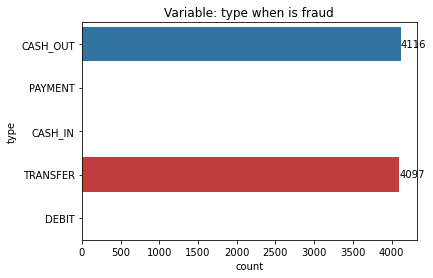

In [18]:
plt.title(f'Variable: type when is fraud')
ax = sns.countplot(data = df.query('isFraud == 1'), y = 'type', order=df['type'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.show()

Vemos que de todo el histórico, solo ha ocurrido fraude en transacciones tipo CASH_OUT y TRANSFER. 

### Variable de salida

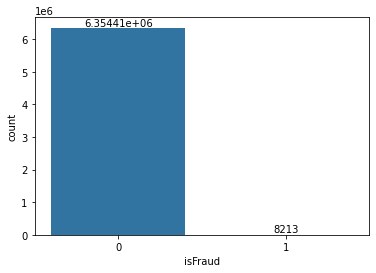

In [19]:
ax = sns.countplot(data = df, x = 'isFraud')
ax.bar_label(ax.containers[0])
plt.show()

In [20]:
df['isFraud'].value_counts(normalize=True)*100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

Se presenta un serio desbalance en la variable de salida, siendo solo 8213 (0.13%) fraudulentas.

### Preprocessing

Para este caso se procederá a eliminar las variables con alta representatividad y aplicar OHE a la variable type

In [21]:
# Borramos columnas con alta representatividad
df.drop(columns = ['nameOrig', 'nameDest'], inplace = True)

In [22]:
# Aplicamos OHE
type_ohe = pd.get_dummies(df['type'], drop_first=True)

# Concatenamos
df = pd.concat([df, type_ohe], axis=1)

# Borramos columna original 
df.drop(columns = ['type'], inplace = True)

In [23]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,1,0


### Modeling

#### Train test split

In [24]:
X, y = df.drop(['isFraud'], axis=1), df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)


In [25]:
# Chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (4771965, 10)
Testeo: (1590655, 10)

Clases train:
0    0.998709
1    0.001291
Name: isFraud, dtype: float64

Clases test:
0    0.998709
1    0.001291
Name: isFraud, dtype: float64


El desbalance entre las clases se mantiene tanto en train como en test

#### Regresión logística

In [26]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC 

In [27]:
results = {}

In [28]:
# Logistic regression code

scaler = StandardScaler()  

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lr_model = LogisticRegressionCV(scoring='f1')

lr_model.fit(X_train_scaled, y_train)

y_pred_LR = lr_model.predict(X_test_scaled)

y_pred_probas_LR = lr_model.predict_proba(X_test_scaled)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.90      0.48      0.63      2053

    accuracy                           1.00   1590655
   macro avg       0.95      0.74      0.81   1590655
weighted avg       1.00      1.00      1.00   1590655



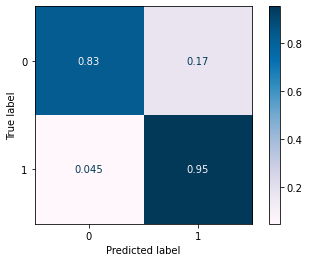

In [29]:
a = plot_confusion_matrix(lr_model, X_test, y_test, cmap = 'PuBu', normalize = 'true')
print(classification_report(y_test, y_pred_LR))

In [87]:
acc = accuracy_score(y_test, y_pred_LR)
rec = recall_score(y_true = y_test, y_pred = y_pred_LR)
f1 = f1_score(y_true = y_test, y_pred = y_pred_LR)

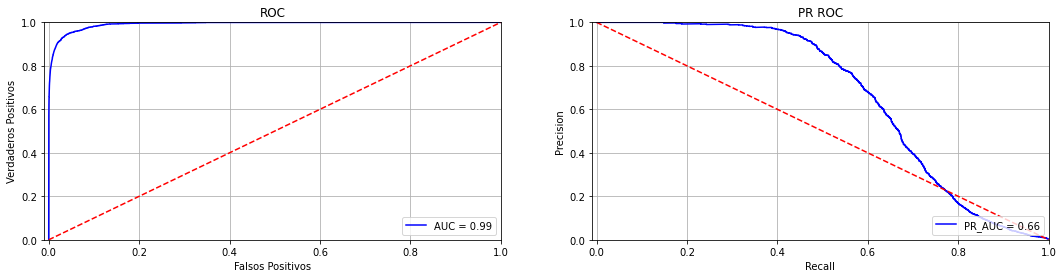

In [74]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas_LR[:,1])
roc_auc = auc(fpr, tpr)

pr_pre, pr_rec, threshold = precision_recall_curve(y_test, y_pred_probas_LR[:,1])
pr_roc_auc = auc(pr_rec, pr_pre)

plot_roc(fpr, tpr, roc_auc, pr_rec, pr_pre, pr_roc_auc)

In [88]:
results['modelLR'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc, 'pr_auc': pr_roc_auc}
results['modelLR']


{'acc': 0.999260681920341,
 'rec': 0.48075986361422307,
 'f1': 0.6266666666666666,
 'auc': 0.8606894216915452,
 'pr_auc': 0.726099504629135}

El accuracy del modelo es muy bueno, pero esto es debido al desbalance entre las clases. Tanto el f1 score como la curva precision-recall dejan mucho que desear aún.

#### Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier

In [81]:
# Usando el modelo DT (no es necesario escalar los datos en modelos tipo árbol)
dt_model = DecisionTreeClassifier(max_depth = 5)

# fit model
dt_model.fit(X_train, y_train)

y_pred_DT = dt_model.predict(X_test)

y_pred_probas_DT = dt_model.predict_proba(X_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.80      0.70      0.75      2053

    accuracy                           1.00   1590655
   macro avg       0.90      0.85      0.87   1590655
weighted avg       1.00      1.00      1.00   1590655



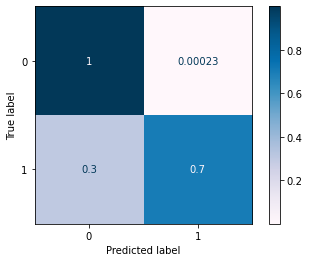

In [82]:
a = plot_confusion_matrix(dt_model, X_test, y_test, cmap = 'PuBu', normalize = 'true')
print(classification_report(y_test, y_pred_DT))

In [144]:
acc = accuracy_score(y_test, y_pred_DT)
rec = recall_score(y_true = y_test, y_pred = y_pred_DT)
f1 = f1_score(y_true = y_test, y_pred = y_pred_DT)

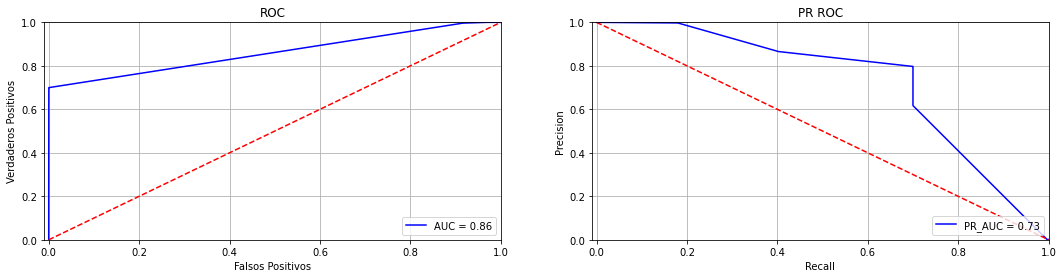

In [145]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas_DT[:,1])
roc_auc = auc(fpr, tpr)

pr_pre, pr_rec, threshold = precision_recall_curve(y_test, y_pred_probas_DT[:,1])
pr_roc_auc = auc(pr_rec, pr_pre)

plot_roc(fpr, tpr, roc_auc, pr_rec, pr_pre, pr_roc_auc)

In [146]:
results['modelDT'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc, 'pr_auc': pr_roc_auc}
results['modelDT']

{'acc': 0.9993826442566113,
 'rec': 0.6994641987335607,
 'f1': 0.745199792423456,
 'auc': 0.8606894216915452,
 'pr_auc': 0.726099504629135}

Se ve que el modelo está performando mejor en la clase mayoritaria. Por lo que emplearé incorporaré en la función de costos del algoritmo un mayor peso para los errores de entrenamiento cometidos sobre los puntos de la clase minoritaria. Empleando el argumento "class_weight"  en un modelo de random forest

#### Random Forest

In [93]:
# Usando el modelo Random Forest (no es necesario escalar los datos en modelos tipo árbol)
rf_model = RandomForestClassifier(n_estimators = 100, max_depth = 5, class_weight = "balanced", random_state = 0, n_jobs = -1)

# fit model
rf_model.fit(X_train, y_train)

y_pred_RF = rf_model.predict(X_test)

y_pred_probas_RF = rf_model.predict_proba(X_test)


In [97]:
classification_report(y_test, y_pred_RF)

'              precision    recall  f1-score   support\n\n           0       1.00      0.97      0.98   1588602\n           1       0.04      0.97      0.07      2053\n\n    accuracy                           0.97   1590655\n   macro avg       0.52      0.97      0.53   1590655\nweighted avg       1.00      0.97      0.98   1590655\n'

              precision    recall  f1-score   support

           0       1.00      0.97      0.98   1588602
           1       0.04      0.97      0.07      2053

    accuracy                           0.97   1590655
   macro avg       0.52      0.97      0.53   1590655
weighted avg       1.00      0.97      0.98   1590655



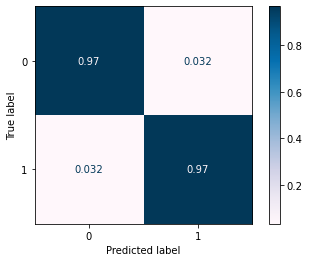

In [131]:
a = plot_confusion_matrix(rf_model, X_test, y_test, cmap = 'PuBu', normalize = 'true')
print(classification_report(y_test, y_pred_RF))

In [147]:
acc = accuracy_score(y_test, y_pred_RF)
rec = recall_score(y_true = y_test, y_pred = y_pred_RF)
f1 = f1_score(y_true = y_test, y_pred = y_pred_RF)

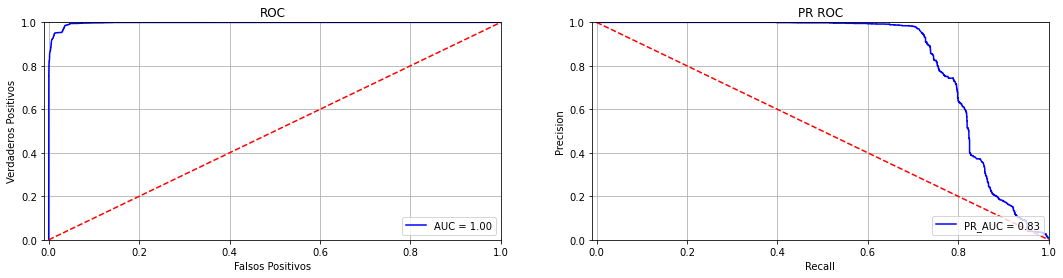

In [148]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas_RF[:,1])
roc_auc = auc(fpr, tpr)

pr_pre, pr_rec, threshold = precision_recall_curve(y_test, y_pred_probas_RF[:,1])
pr_roc_auc = auc(pr_rec, pr_pre)

plot_roc(fpr, tpr, roc_auc, pr_rec, pr_pre, pr_roc_auc)

In [149]:
results['modelRF'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc, 'pr_auc': pr_roc_auc}
results['modelRF']

{'acc': 0.9676705508108295,
 'rec': 0.9683390160740379,
 'f1': 0.0717676576235086,
 'auc': 0.9972527656042681,
 'pr_auc': 0.8267480466679614}

#### Modelo tipo Boosting LIGTHGBM

In [138]:
lgbm_model = LGBMClassifier(max_depth=5, random_state = 42, class_weight='balanced')
lgbm_model.fit(X_train, y_train)
lgbm_model.score(X_train, y_train)

y_pred_LGBM = lgbm_model.predict(X_test)
y_pred_probas_LGBM = lgbm_model.predict_proba(X_test)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1588602
           1       0.15      1.00      0.26      2053

    accuracy                           0.99   1590655
   macro avg       0.57      1.00      0.63   1590655
weighted avg       1.00      0.99      1.00   1590655



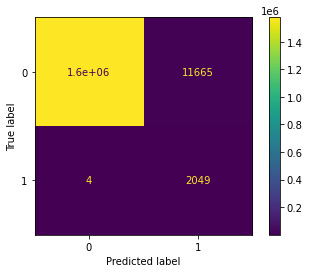

In [139]:
a = plot_confusion_matrix(lgbm_model, X_test, y_test)
print(classification_report(y_test, y_pred_LGBM))

In [140]:
acc = accuracy_score(y_test, y_pred_LGBM)
rec = recall_score(y_true = y_test, y_pred = y_pred_LGBM)
f1 = f1_score(y_true = y_test, y_pred = y_pred_LGBM)

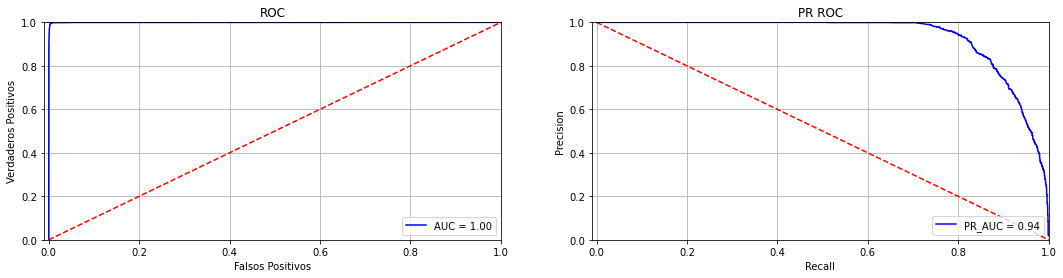

In [141]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probas_LGBM[:,1])
roc_auc = auc(fpr, tpr)

pr_pre, pr_rec, threshold = precision_recall_curve(y_test, y_pred_probas_LGBM[:,1])
pr_roc_auc = auc(pr_rec, pr_pre)

plot_roc(fpr, tpr, roc_auc, pr_rec, pr_pre, pr_roc_auc)

In [142]:
results['modelLGBM'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc, 'pr_auc': pr_roc_auc}
results['modelLGBM']

{'acc': 0.9926640283405264,
 'rec': 0.9980516317584024,
 'f1': 0.25990993847910193,
 'auc': 0.9997763928003254,
 'pr_auc': 0.9355497591080779}

### Comparación Modelos

In [154]:
df_results = pd.DataFrame.from_dict(results).T
df_results

,acc,rec,f1,auc,pr_auc
modelLR,0.999261,0.480760,0.626667,0.860689,0.726100
modelDT,0.999383,0.699464,0.745200,0.860689,0.726100
modelRF,0.967671,0.968339,0.071768,0.997253,0.826748
modelLGBM,0.992664,0.998052,0.259910,0.999776,0.935550


Dado el desbalance entre los datos, la métrica que determina cuál modelo es mejor es la ROC precision-recall. En este caso, resulta ganador el modelo de LightGBM, para describir un balance entre las predicciones de las transacciones fraudulentas y que en verdad fueron fraudulentas.